In [1]:
import numpy as np
import cifar100 as cf
import matplotlib.pyplot as plt

In [233]:
imgs, labels  = cf.load_data(cf.file_path+"train")
Xtest , Ytest = cf.load_data(cf.file_path+"test")

s = np.random.permutation(imgs.shape[0])           # randomly shuffle the images and their corresponding labels
imgs   = imgs[s]
labels = labels[s]

Xtr = imgs[:45000]                   # 90 % of the data is used for training
Ytr = labels[:45000]
Xval = imgs[45000:]                  # 10 % for validation
Yval = labels[45000:]

In [234]:
mean_img = Xtr.mean()

Xtr  = cf.zero_center(Xtr, mean_img)     # zero center validation and training data
Xval = cf.zero_center(Xval, mean_img)
Xtest = cf.zero_center(Xtest, mean_img)

Xtr  = cf.convert_images(Xtr)           # scale image values to 0..1
Xval = cf.convert_images(Xval)
Xtest = cf.convert_images(Xtest)

In [ ]:
s = np.random.permutation(Xtr.shape[0])
Xtr_shuffled = Xtr[s]
Ytr_shuffled = Ytr[s]
m = len(Ytr)
Xtr_batch = Xtr_shuffled[m: m + batch_size] 
Ytr_batch = Ytr_shuffled[m: m + batch_size]   

In [357]:
class NeuralNetwork():
    
    def __init__(self,D,k,hidden_layers,nodes,activ=0):   # D input dimensionality , K output dimensionality
        self.activation_func = 0
        # Initialize Network Paramaters
        self.hidden_layers = hidden_layers     # Number of hidden layers
        self.nodes = nodes                     # list of number of nodes per layer
      
        self.k = k
        self.D = D
       
        
       
    def InitWeights(self):
        
        # Initialize Weights 
        self.Weights = np.empty(self.hidden_layers+1,dtype = object)                     # list of network weights
        self.Weights[0]   = np.random.randn(self.D,self.nodes[0])/ np.sqrt(self.D/2.0)                   # first layer Weights [D X l1_nodes]
        self.Weights[1:-1]= [np.random.randn(self.nodes[i-1],self.nodes[i])/np.sqrt(self.D/2.0) for i in range(1,self.hidden_layers)] 
        self.Weights[-1]  =  np.random.randn(self.nodes[self.hidden_layers-1] , self.k)/ np.sqrt(self.D/2.0)  
        
        # Initialize Bias
        self.b = np.empty(self.hidden_layers+1,dtype = object)           # list of network biases
        self.b[0:-1] = [np.zeros((1,self.nodes[i])) for i in range(self.hidden_layers)]   # [1 X li_nodes]
        self.b[-1] = np.zeros((1,self.k))                                            # [1 X output_nodes]
       
        # Initialize layers activations
        self.h = np.empty(self.hidden_layers, dtype=object)           # list of hidden layers activations
        self.out = np.zeros((self.k,1))                               # output scores [k X 1]
        
          
        self.mog = 0                         # Initialize momentum and accumalation values to zero
        self.ACCg = 0
        
        self.mob = 0
        self.ACCb = 0
        
        #print(self.Weights)
        #print(self.b)
        #print(self.out)
        #print(self.h)
    
    def forwardP(self,x , y):
 
        f = self.__activ_func()                            
        self.h[0] = f(np.dot(x, self.Weights[0])+ self.b[0])          # [1 X l0_nodes]
        self.h[1:] = [ f(np.dot(self.h[i-1], self.Weights[i])+ self.b[i]) for i in range(1,self.hidden_layers)]
        self.out = np.dot(self.h[-1], self.Weights[-1])+ self.b[-1] 
        
        #print("acitvation\n",self.h)
        #print("output\n", self.out)
        return self.out
    
    def forwardPtest(self, x,y, Weights, b):
        f = self.__activ_func()                            
        self.h[0] = f(np.dot(x, Weights[0])+ b[0])          # [1 X l0_nodes]
        self.h[1:] = [ f(np.dot(self.h[i-1], Weights[i])+ b[i]) for i in range(1,self.hidden_layers)]
        self.out = np.dot(self.h[-1], Weights[-1])+ b[-1]      
        return self.out
    
    
    # Computes cross entropy loss
    def loss(self , output, correct_labels):
        num_points = output.shape[0]
        exp_scores = np.exp(output)            # apply softmax function
        probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
        NLL = -np.log(probs[range(num_points) ,correct_labels])   # negative log likelihood of the correct class probability
        data_loss = np.sum(NLL)/num_points
       
        # L2 Regularization
        Wsqr = self.Weights * self.Weights  
        wreg_loss = [np.sum(Wsqr[i]) for i in range(Wsqr.shape[0])]   # sum all the squared elements of W
        reg_loss  =  0.5*self.reg *np.sum(wreg_loss)                  # multiply by the regularization paramater
        
        return (reg_loss + data_loss) , probs
        
    def backwardP(self, probs,Xtr_batch, Ytr_batch):
        dw = np.empty(self.hidden_layers+1, dtype = object)              # partial derivative with respect to Weights 
        dh = np.empty(self.hidden_layers, dtype = object)                # error of hidden layr h
        db = np.empty(self.hidden_layers+1, dtype = object)              # partial derviative with respect to the bias
        
        num_points = self.out.shape[0]   
        
        dscores = probs                                          # output error delta of the last layer
        dscores[range(num_points), Ytr_batch] -= 1               # correct class probability - target(1)
        dscores = dscores / num_points                           # average the gradient of the batch
        
        db[-1] = np.sum(dscores, axis = 0, keepdims = True)      # Bias partial derivative  of the last hidden layer
        
        # backpropagate the gradient to the weights
        # last layer weights
        dw[-1] = np.dot(np.transpose(self.h[-1]), dscores)
        
        # backpropagate to the hidden layers
        dh[-1] = np.dot(dscores, np.transpose(self.Weights[-1]))
        df=self.__dactiv_func()
        dh[-1] = dh[-1] * df(self.h[-1])                            # element wise multiplication
        
        db[self.hidden_layers-1] = np.sum(dh[-1], axis=0, keepdims = True)
        
        for i in range(self.hidden_layers-2, -1, -1):
            dh[i] = np.dot(dh[i+1], np.transpose(self.Weights[i+1]))   # hidden error
            dh[i] = dh[i] * df(self.h[i])                          # hidden error multiplied by partial derivative of activation h
            db[i] = np.sum(dh[i], axis=0, keepdims= True)

        dw[0] = np.dot(np.transpose(Xtr_batch) ,dh[0])
                
        for i in range(1,self.hidden_layers):
            dw[i] = np.dot(np.transpose(self.h[i-1]), dh[i]) 
            
        # Then add regularization contribution to the deltas W
        for i in range(self.hidden_layers+1):
            dw[i] = dw[i] +  self.reg * self.Weights[i]
        
       # print("dw\n", dw)
       # print("dh\n", dh)
       # print("db\n", db)
        
        return dw,db
       
        
    def minibatch(self,Xtr,Ytr, size):
        s = np.random.permutation(Xtr.shape[0])
        Xtr_shuffled = Xtr[s]
        Ytr_shuffled = Ytr[s]
        return Xtr_shuffled[:size,], Ytr_shuffled[:size,]
    
    def updateWeights(self,dw,db):
        # Parameter update Adam
        beta1 = 0.9
        beta2 = 0.99
        # Momentum update
        self.mog = self.mog* beta1 + (1-beta1) * dw
        self.ACCg= beta2 * self.ACCg+ (1-beta2) * dw * dw
        self.Weights +=  -self.alpha * self.mog/ ( (self.ACCg*0.5) + 1*np.exp(-7))
        
        self.mob = self.mob * beta1 + (1-beta1) * db
        self.ACCb = beta2 * self.ACCb + (1-beta2) * db * db
        self.b += -self.alpha * self.mob/ ( (self.ACCb * 0.5) + 1 * np.exp(-7))
         
    def train(self, Xtr, Ytr, Xval, Yval , alpha , reg, num_epochs, activation_func, batch_size):
        
        self.InitWeights()                       # randomly initialize weights
        
        self.alpha = alpha                       # learning rate
        self.activation_func = activation_func   # activation function
        self.reg = reg                           # Regularization Parameter
        
        tr_acc  = []
        val_acc = []
        
        loss_hist = []
        loss_avg = []
        
        train_loss = []
        valid_loss = []
        
        m = len(Ytr)               # Number of training examples 
        Weights_hist = np.empty(num_epochs , dtype = object)
        bias_hist = np.empty(num_epochs, dtype = object)
        # gradient descent loop
        for i in range(num_epochs):
            s = np.random.permutation(Xtr.shape[0])
            Xtr_shuffled = Xtr[s]
            Ytr_shuffled = Ytr[s]
            
            loss = []
            train_accs = []
            for k in range(0,m,batch_size): 
                Xtr_batch = Xtr_shuffled[k: k + batch_size] 
                Ytr_batch = Ytr_shuffled[k: k + batch_size]   
            
                scores = self.forwardP(Xtr_batch, Ytr_batch)                   # forward propagate the training data
                batchloss , probs = self.loss(scores, Ytr_batch)               # calculate the cross entropy loss
                loss.append(batchloss)
                
                loss_hist.append(batchloss)
                
                dw, db = self.backwardP(probs,Xtr_batch, Ytr_batch)            # backpropagate to calculate partial derivative
                self.updateWeights(dw,db)                                      # update Weight paramters
                
                predicted_class = np.argmax(scores, axis = 1)                
                train_acc = np.mean(Ytr_batch == predicted_class)
                train_accs.append(train_acc)                
           
            #validation set accuracy
            val_scores  = self.forwardP(Xval, Yval)
            val_predicted_class = np.argmax(val_scores ,axis = 1 )
            valid_acc = np.mean(val_predicted_class == Yval)
            val_acc.append(valid_acc)
            validloss , probs = self.loss(val_scores, Yval)               # calculate the cross entropy loss
            valid_loss.append(validloss)
        
            
            avg_loss = np.mean(loss)            # average loss across all the batches
            train_loss.append(avg_loss)
            
            avg_train_acc = np.mean(train_accs)
            tr_acc.append(avg_train_acc)
            
            loss_avg.append(avg_loss)
            print("Epoch %d: loss %f , tr_acc %f , val_acc %f , lr %e, reg %e" %(i, avg_loss , avg_train_acc ,valid_acc, self.alpha, self.reg))
            
            Weights_hist[i] = self.Weights
            bias_hist[i] = self.b
                        
        return tr_acc, val_acc , loss_hist ,  train_loss,valid_loss,Weights_hist, bias_hist
    
    def __activ_func(self):
        switcher= {
             0 : lambda x: np.maximum(0,x),             # RelU 
             1 : lambda x: np.maximum(0.01*x, x),       # Leaky Relu
             2 : lambda x: np.tanh(x),                  # tanh
             3 : lambda x: 1.0/ (1+np.exp(-x))          # sigmoid
        }
        return(switcher.get(self.activation_func,"invalid"))
    
    def __dactiv_func(self):
        sigm = lambda x: 1.0/ (1+np.exp(-x))
        switcher= {
             0 : lambda x: self.__dReLU(x) ,
             1 : lambda x: self.__dleakyReLU(x),
             2 : lambda x: 1-tanh(x)**2,
             3 : lambda x: x*(1-x)
        }
        return(switcher.get(self.activation_func,"invalid"))
    
    def __dReLU(self,x):
        dx = np.ones(x.shape)
        dx[x<=0] = 0
        return dx
    
    def __dleakyReLU(self,x):
        x[x<=0.01*x] = 0.01
        x[x>0.01*x]  = 1
        
    def deadNeurons(self):
        count = 0
        for i in range(self.hidden_layers):
            count = count + (np.sum(self.h[i] == 0))
        return count

In [ ]:
nn = NeuralNetwork(3072,20,2,[3072,100])              # Specify Network Archietecure 

In [276]:

# Find Min and Max range of alpha
reg    = 0.0000000001                     # very small regularization
alpha_min = 10**(-10)                     # Loss barely changes
alpha_max = 10**(-2)*8                    # Loss explodes
train_acc , valid_acc, loss_hist, train_loss, valid_loss = nn.train(Xtr,Ytr, Xval, Yval,10**(-2)*8,reg,10,0,256)   # alpha , reg , num_epochs , activ_func , batch_size
# alpha range [10**(-10), 10**(-2)*8]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:232: RuntimeWarning: invalid value encountered in less_equal


Epoch 0: loss nan , tr_acc 0.050349 , val_acc 0.050800 , lr 8.000000e-02, reg 1.000000e-10
Epoch 1: loss nan , tr_acc 0.049905 , val_acc 0.050800 , lr 8.000000e-02, reg 1.000000e-10
Epoch 2: loss nan , tr_acc 0.049911 , val_acc 0.050800 , lr 8.000000e-02, reg 1.000000e-10


KeyboardInterrupt: 

In [295]:
# Optimize hyper-paramaters alpha and regularization paramater
# Coarse Search and fine search loap

models  = np.zeros(100, dtype = float)
alphas  = np.zeros(100, dtype = float)
regs    = np.zeros(100, dtype = float)

for i in range(100):
    
    reg   = 10 ** np.random.uniform(-5,-2)               # search in the log scale
    alpha = 10 ** np.random.uniform(-3, -4)             # in the max and min rang of alpha
    
    train_acc , valid_acc,loss_hist,train_loss,valid_loss = nn.train(Xtr,Ytr, Xval, Yval,alpha,reg,5,0,256)   # alpha , reg , num_epochs , activ_func , batch_size
    max_valid =    max(valid_acc)         #max(valid_acc)
    
    models[i] = max_valid
    
    alphas[i] = alpha
    regs[i] = reg
    
    print("iteration %d:  val_acc %f , lr %e , reg %e" %(i,max_valid, alpha, reg))
    

iteration 0:  val_acc 0.363200 , lr 5.365764e-04 , reg 1.010533e-04
iteration 1:  val_acc 0.349800 , lr 6.132755e-04 , reg 5.730617e-04
iteration 2:  val_acc 0.373600 , lr 4.731296e-04 , reg 3.152739e-04
iteration 3:  val_acc 0.358600 , lr 2.679700e-04 , reg 7.807264e-04
iteration 4:  val_acc 0.363400 , lr 5.237534e-04 , reg 1.551368e-04
iteration 5:  val_acc 0.346000 , lr 1.852711e-04 , reg 4.189855e-03
iteration 6:  val_acc 0.355400 , lr 5.690456e-04 , reg 5.026242e-05
iteration 7:  val_acc 0.345200 , lr 1.319365e-04 , reg 6.950059e-05
iteration 8:  val_acc 0.348200 , lr 2.052078e-04 , reg 2.397977e-03
iteration 9:  val_acc 0.365000 , lr 1.999290e-04 , reg 4.115074e-04
iteration 10:  val_acc 0.341600 , lr 2.890525e-04 , reg 3.982167e-03
iteration 11:  val_acc 0.363800 , lr 1.789513e-04 , reg 2.196567e-03
iteration 12:  val_acc 0.367000 , lr 5.737653e-04 , reg 4.902973e-05
iteration 13:  val_acc 0.359800 , lr 1.814004e-04 , reg 6.720485e-04
iteration 14:  val_acc 0.358800 , lr 1.67730

In [296]:
# find best models
best_model = np.argsort(models)[::-1]

for i in range(20):
    print(" model %d ,val_acc %f , lr %e, reg %e" %(i , models[best_model[i]] , alphas[best_model[i]] , regs[best_model[i]] ))

 model 0 ,val_acc 0.383400 , lr 3.268817e-04, reg 4.635987e-05
 model 1 ,val_acc 0.375000 , lr 6.721996e-04, reg 1.797639e-04
 model 2 ,val_acc 0.373600 , lr 4.731296e-04, reg 3.152739e-04
 model 3 ,val_acc 0.370800 , lr 3.709931e-04, reg 1.459414e-04
 model 4 ,val_acc 0.370200 , lr 2.341366e-04, reg 8.308545e-05
 model 5 ,val_acc 0.369800 , lr 4.759340e-04, reg 6.613195e-04
 model 6 ,val_acc 0.368800 , lr 4.436010e-04, reg 6.133072e-04
 model 7 ,val_acc 0.367400 , lr 3.154784e-04, reg 2.315520e-03
 model 8 ,val_acc 0.367400 , lr 2.634194e-04, reg 2.290894e-04
 model 9 ,val_acc 0.367000 , lr 5.737653e-04, reg 4.902973e-05
 model 10 ,val_acc 0.367000 , lr 4.328397e-04, reg 6.277815e-05
 model 11 ,val_acc 0.366800 , lr 2.682083e-04, reg 5.435847e-05
 model 12 ,val_acc 0.366200 , lr 3.311609e-04, reg 1.193097e-05
 model 13 ,val_acc 0.366000 , lr 7.272097e-04, reg 4.658154e-04
 model 14 ,val_acc 0.365800 , lr 3.967248e-04, reg 6.718997e-04
 model 15 ,val_acc 0.365800 , lr 6.617585e-04, reg

In [347]:
# Train with model 0

alpha = 3.268817 * (10**(-4))
reg   = 4.635987 * (10**(-5))

print(" reg %e" %(reg))
print(" reg %e" %(alpha))

train_acc,valid_acc,loss_hist,train_loss,valid_loss,weight_hist,b_hist= nn.train(Xtr,Ytr, Xval, Yval,alpha,reg,50,0,256)


 reg 4.635987e-05
 reg 3.268817e-04
Epoch 0: loss 2.678835 , tr_acc 0.223106 , val_acc 0.289400 , lr 3.268817e-04, reg 4.635987e-05
Epoch 1: loss 2.373533 , tr_acc 0.314338 , val_acc 0.317600 , lr 3.268817e-04, reg 4.635987e-05
Epoch 2: loss 2.228658 , tr_acc 0.361258 , val_acc 0.350400 , lr 3.268817e-04, reg 4.635987e-05
Epoch 3: loss 2.109783 , tr_acc 0.391217 , val_acc 0.358400 , lr 3.268817e-04, reg 4.635987e-05
Epoch 4: loss 1.993349 , tr_acc 0.425167 , val_acc 0.369800 , lr 3.268817e-04, reg 4.635987e-05
Epoch 5: loss 1.890081 , tr_acc 0.459747 , val_acc 0.363200 , lr 3.268817e-04, reg 4.635987e-05
Epoch 6: loss 1.794382 , tr_acc 0.486589 , val_acc 0.376400 , lr 3.268817e-04, reg 4.635987e-05
Epoch 7: loss 1.689488 , tr_acc 0.520051 , val_acc 0.373200 , lr 3.268817e-04, reg 4.635987e-05
Epoch 8: loss 1.596503 , tr_acc 0.551795 , val_acc 0.369000 , lr 3.268817e-04, reg 4.635987e-05
Epoch 9: loss 1.497654 , tr_acc 0.582439 , val_acc 0.369400 , lr 3.268817e-04, reg 4.635987e-05
Epoc

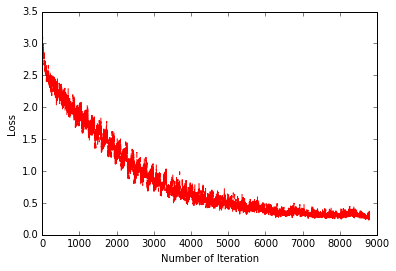

In [351]:
# Monitor loss versus number of epochs
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
x = np.arange(len(loss_hist))
plt.plot(x, loss_hist, 'r--')
plt.show()

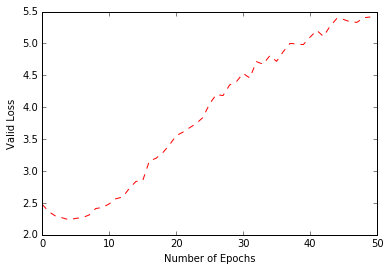

[2.4783631328534477, 2.3616221865511537, 2.2930251810318496, 2.2659824416056522, 2.23643469634023, 2.2573466730021856, 2.2695935256552557, 2.3100466220048146, 2.4122203639085869, 2.4284649867586148, 2.4850703138674564, 2.5661252238019978, 2.5906688090627088, 2.7254805484950069, 2.8369740258650569, 2.8460317353244564, 3.1572414597128713, 3.2002041912974293, 3.286916000830221, 3.4084363596545852, 3.5538363919419664, 3.608985202020448, 3.67821219902038, 3.7450528388332716, 3.8389898309938926, 4.0534312173964731, 4.2010223950957704, 4.1828270460849, 4.3502343172675086, 4.4005952421380634, 4.5318876620910657, 4.4592607686400427, 4.7154667722484653, 4.674860608383975, 4.8094276757507997, 4.7199432630552085, 4.8713653631784695, 5.0005906984105426, 4.9932125452442095, 4.9829682699843145, 5.0986490973980354, 5.2049468766641542, 5.111334865064328, 5.27164887630338, 5.3921679606521851, 5.3764025341194648, 5.3399569006635454, 5.3312628562300937, 5.4041103866783482, 5.4155336150564191]


In [355]:
# Monitor loss versus number of epochs
plt.xlabel("Number of Epochs")
plt.ylabel("Valid Loss")
x = np.arange(len(valid_loss))
plt.plot(x, valid_loss, 'r--')
plt.show()
print(valid_loss)

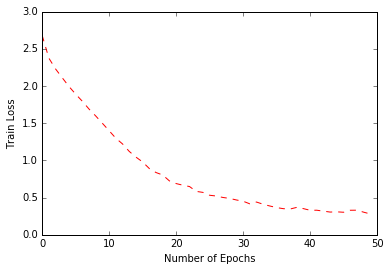

In [353]:
plt.xlabel("Number of Epochs")
plt.ylabel("Train Loss")
x = np.arange(len(train_loss))
plt.plot(x, train_loss, 'r--')
plt.show()

[0.28939999999999999, 0.31759999999999999, 0.35039999999999999, 0.3584, 0.36980000000000002, 0.36320000000000002, 0.37640000000000001, 0.37319999999999998, 0.36899999999999999, 0.36940000000000001, 0.36799999999999999, 0.37419999999999998, 0.37719999999999998, 0.38, 0.36380000000000001, 0.38279999999999997, 0.35399999999999998, 0.36459999999999998, 0.3624, 0.36599999999999999, 0.36799999999999999, 0.36919999999999997, 0.35859999999999997, 0.37, 0.37740000000000001, 0.37, 0.37280000000000002, 0.37759999999999999, 0.37280000000000002, 0.36620000000000003, 0.3614, 0.36919999999999997, 0.37080000000000002, 0.37059999999999998, 0.37540000000000001, 0.37219999999999998, 0.36880000000000002, 0.36940000000000001, 0.36420000000000002, 0.377, 0.36859999999999998, 0.37280000000000002, 0.37919999999999998, 0.37519999999999998, 0.374, 0.36880000000000002, 0.37040000000000001, 0.36859999999999998, 0.37959999999999999, 0.37859999999999999]


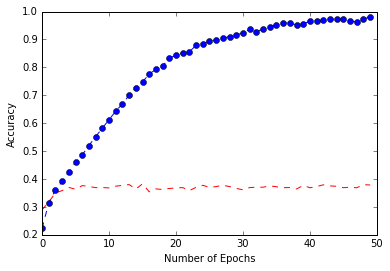

In [379]:
# Monitor valid accuracy versus training accuracy
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
print(valid_acc)
x = np.arange(len(valid_acc))
plt.plot(x, valid_acc, 'r--')
plt.plot(x, train_acc, 'o--')
plt.show()

In [380]:
# apply testing test
def activ_func(x):
        switcher= {
             0 : lambda x: np.maximum(0,x),
             1 : lambda x: np.maximum(0.01*x, x),
             2 : lambda x: np.tanh(x),
             3 : lambda x: 1.0/ (1+np.exp(-x))
        }
        return(switcher.get(x,"invalid"))
    
def forwardPtest( x,y, Weights, b):
    h = np.empty(2, dtype=object)           # list of hidden layers activations
    f = activ_func(0)                            
    h[0] = f(np.dot(x, Weights[0])+ b[0])          # [1 X l0_nodes]
    h[1:] = [ f(np.dot(h[i-1], Weights[i])+ b[i]) for i in range(1,2)]
    out = np.dot(h[-1], Weights[-1])+ b[-1]      
    return out
    
scores = forwardPtest(Xtest, Ytest,weight_hist[13], b_hist[13])     # test with the model with the heighest accuracy
predicted_class = np.argmax(scores, axis = 1)                
test_acc = np.mean(Ytest == predicted_class)
print("ACCR %f" %(test_acc))

ACCR 0.370500


In [376]:
number_classes = 20
def ccrn(Ypredicted, Ytest):
    Ytest_l = Ytest.tolist()
    class_occurence  = [ Ytest_l.count(i) for i in range(number_classes)]  
    correct_y = np.zeros((number_classes), dtype = np.float)
    for i in range(number_classes): 
        for j in range(len(Ytest)):
            if ( Ytest[j] == Ypredicted[j] and Ytest[j] == i):
                correct_y[i] = correct_y[i] + 1
    ccrn = correct_y / class_occurence
    return ccrn

In [378]:
# Correct classification rate
cc_rate = ccrn(predicted_class , Ytest)
for i in range(len(cc_rate)):
    print("class %d ,ccrn %f" %(i ,cc_rate[i]))


class 0 ,ccrn 0.288000
class 1 ,ccrn 0.422000
class 2 ,ccrn 0.538000
class 3 ,ccrn 0.432000
class 4 ,ccrn 0.442000
class 5 ,ccrn 0.384000
class 6 ,ccrn 0.370000
class 7 ,ccrn 0.400000
class 8 ,ccrn 0.226000
class 9 ,ccrn 0.464000
class 10 ,ccrn 0.470000
class 11 ,ccrn 0.274000
class 12 ,ccrn 0.246000
class 13 ,ccrn 0.210000
class 14 ,ccrn 0.432000
class 15 ,ccrn 0.226000
class 16 ,ccrn 0.292000
class 17 ,ccrn 0.654000
class 18 ,ccrn 0.262000
class 19 ,ccrn 0.378000


Epoch 0: loss 2.969575 , tr_acc 0.216511 , val_acc 0.295600 , lr 3.268817e-04, reg 1.380000e-04
Epoch 1: loss 2.659475 , tr_acc 0.314704 , val_acc 0.323600 , lr 3.268817e-04, reg 1.380000e-04
Epoch 2: loss 2.510266 , tr_acc 0.357084 , val_acc 0.342000 , lr 3.268817e-04, reg 1.380000e-04
Epoch 3: loss 2.394744 , tr_acc 0.390341 , val_acc 0.360600 , lr 3.268817e-04, reg 1.380000e-04
Epoch 4: loss 2.273481 , tr_acc 0.426093 , val_acc 0.362400 , lr 3.268817e-04, reg 1.380000e-04
Epoch 5: loss 2.171519 , tr_acc 0.455431 , val_acc 0.373800 , lr 3.268817e-04, reg 1.380000e-04
Epoch 6: loss 2.077052 , tr_acc 0.482000 , val_acc 0.369400 , lr 3.268817e-04, reg 1.380000e-04
Epoch 7: loss 1.973945 , tr_acc 0.516419 , val_acc 0.383800 , lr 3.268817e-04, reg 1.380000e-04
Epoch 8: loss 1.885481 , tr_acc 0.541953 , val_acc 0.373600 , lr 3.268817e-04, reg 1.380000e-04
Epoch 9: loss 1.788338 , tr_acc 0.575634 , val_acc 0.381200 , lr 3.268817e-04, reg 1.380000e-04
Epoch 10: loss 1.687909 , tr_acc 0.60579

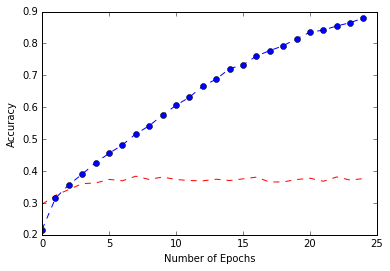

Epoch 0: loss 3.820253 , tr_acc 0.218462 , val_acc 0.284800 , lr 3.268817e-04, reg 4.140000e-04
Epoch 1: loss 3.457406 , tr_acc 0.313433 , val_acc 0.321200 , lr 3.268817e-04, reg 4.140000e-04
Epoch 2: loss 3.267915 , tr_acc 0.352881 , val_acc 0.351200 , lr 3.268817e-04, reg 4.140000e-04
Epoch 3: loss 3.101690 , tr_acc 0.390051 , val_acc 0.364000 , lr 3.268817e-04, reg 4.140000e-04
Epoch 4: loss 2.957579 , tr_acc 0.417767 , val_acc 0.357200 , lr 3.268817e-04, reg 4.140000e-04
Epoch 5: loss 2.822452 , tr_acc 0.444942 , val_acc 0.364000 , lr 3.268817e-04, reg 4.140000e-04
Epoch 6: loss 2.694988 , tr_acc 0.476831 , val_acc 0.374200 , lr 3.268817e-04, reg 4.140000e-04
Epoch 7: loss 2.573865 , tr_acc 0.502810 , val_acc 0.375600 , lr 3.268817e-04, reg 4.140000e-04
Epoch 8: loss 2.465085 , tr_acc 0.528612 , val_acc 0.371600 , lr 3.268817e-04, reg 4.140000e-04
Epoch 9: loss 2.360946 , tr_acc 0.550509 , val_acc 0.374200 , lr 3.268817e-04, reg 4.140000e-04
Epoch 10: loss 2.243495 , tr_acc 0.58135

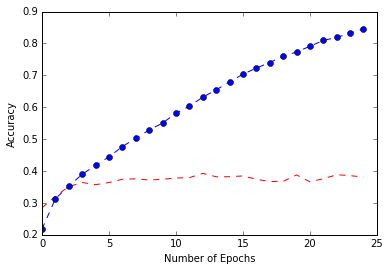

Epoch 0: loss 3.294757 , tr_acc 0.218279 , val_acc 0.292400 , lr 3.268817e-04, reg 2.420000e-04
Epoch 1: loss 2.962425 , tr_acc 0.316878 , val_acc 0.327400 , lr 3.268817e-04, reg 2.420000e-04
Epoch 2: loss 2.809586 , tr_acc 0.355320 , val_acc 0.336000 , lr 3.268817e-04, reg 2.420000e-04
Epoch 3: loss 2.681835 , tr_acc 0.393377 , val_acc 0.365600 , lr 3.268817e-04, reg 2.420000e-04
Epoch 4: loss 2.555832 , tr_acc 0.423143 , val_acc 0.368800 , lr 3.268817e-04, reg 2.420000e-04
Epoch 5: loss 2.450204 , tr_acc 0.450581 , val_acc 0.366000 , lr 3.268817e-04, reg 2.420000e-04
Epoch 6: loss 2.343354 , tr_acc 0.479429 , val_acc 0.369600 , lr 3.268817e-04, reg 2.420000e-04
Epoch 7: loss 2.248091 , tr_acc 0.507013 , val_acc 0.374000 , lr 3.268817e-04, reg 2.420000e-04
Epoch 8: loss 2.135861 , tr_acc 0.543638 , val_acc 0.383200 , lr 3.268817e-04, reg 2.420000e-04
Epoch 9: loss 2.055307 , tr_acc 0.563099 , val_acc 0.377400 , lr 3.268817e-04, reg 2.420000e-04
Epoch 10: loss 1.949299 , tr_acc 0.59731

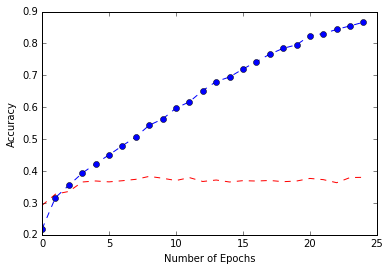

In [348]:
""" Trying to fine tune regularization paramater to overcome overfitting , but all the models gave relatively the same validation accuracy """
nn2 = NeuralNetwork(3072,20,2,[3072,100])              # Specify Network Archietecure 
reg   = 4.635987 * (10**(-5))
alpha = 3.268817 * (10**(-4))

regs = [13.8*10**(-5) , 41.4*10**(-5) , 24.2*10**(-5)]   # increase regularization paramater by a factor of 3

for i in range(len(regs)):
    train_acc2 , valid_acc2 ,loss_hist2 ,train_loss2,valid_loss2,w_hist2,b_hist2 = nn2.train(Xtr,Ytr, Xval, Yval,alpha,regs[i],25,0,256)
    plt.figure(i)
    plt.xlabel("Number of Epochs") 
    plt.ylabel("Accuracy")
    x = np.arange(len(valid_acc2))
    plt.plot(x, valid_acc2, 'r--')
    plt.plot(x, train_acc2, 'o--')
    plt.show()      